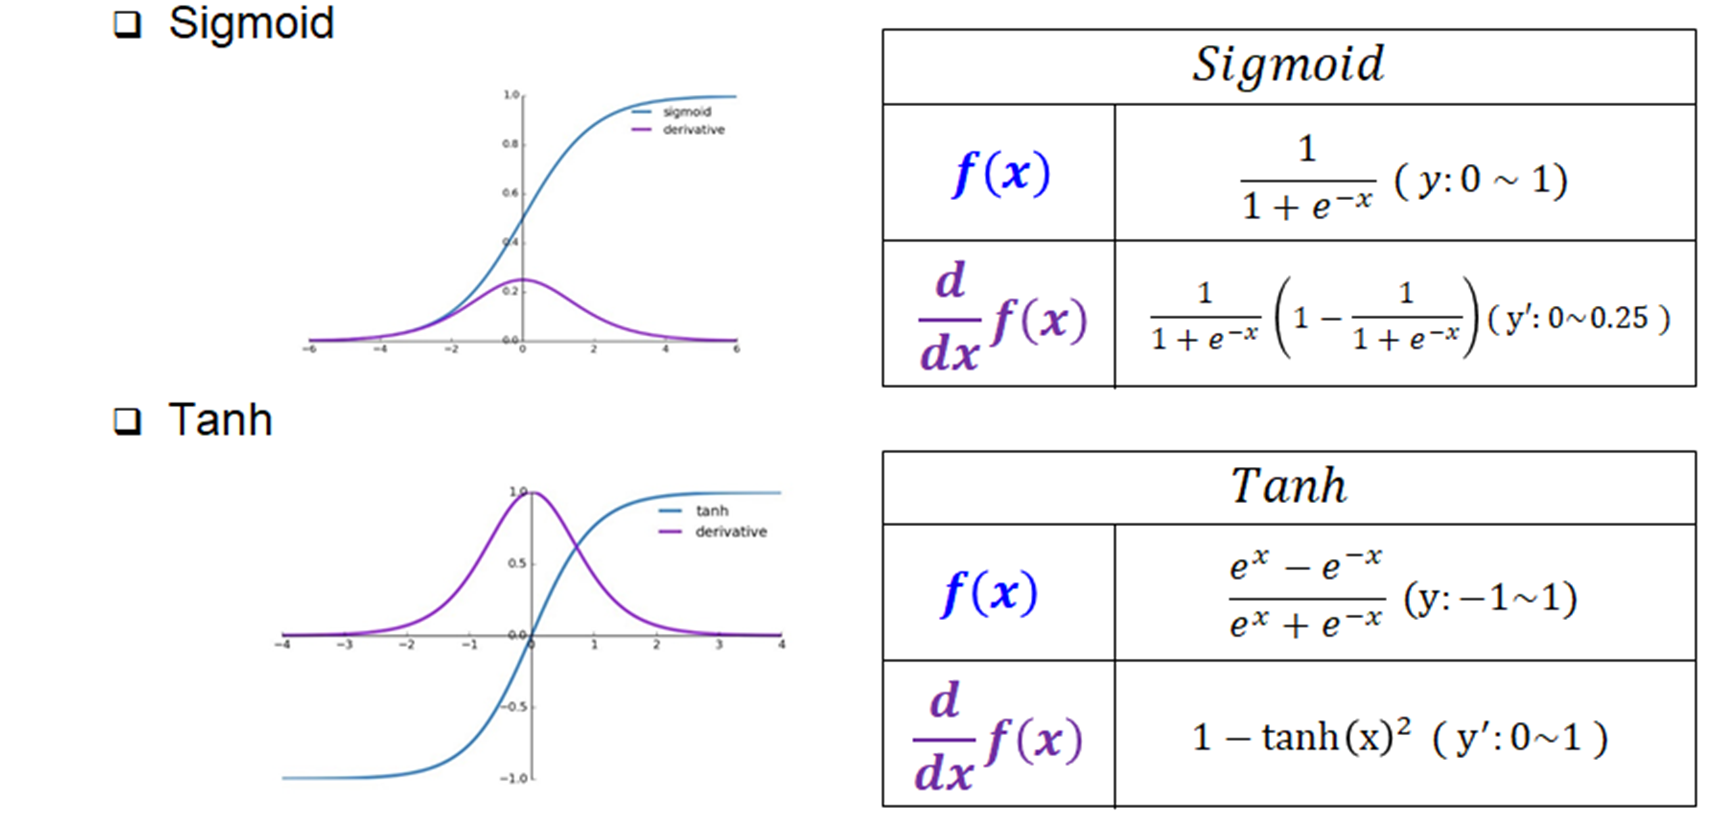

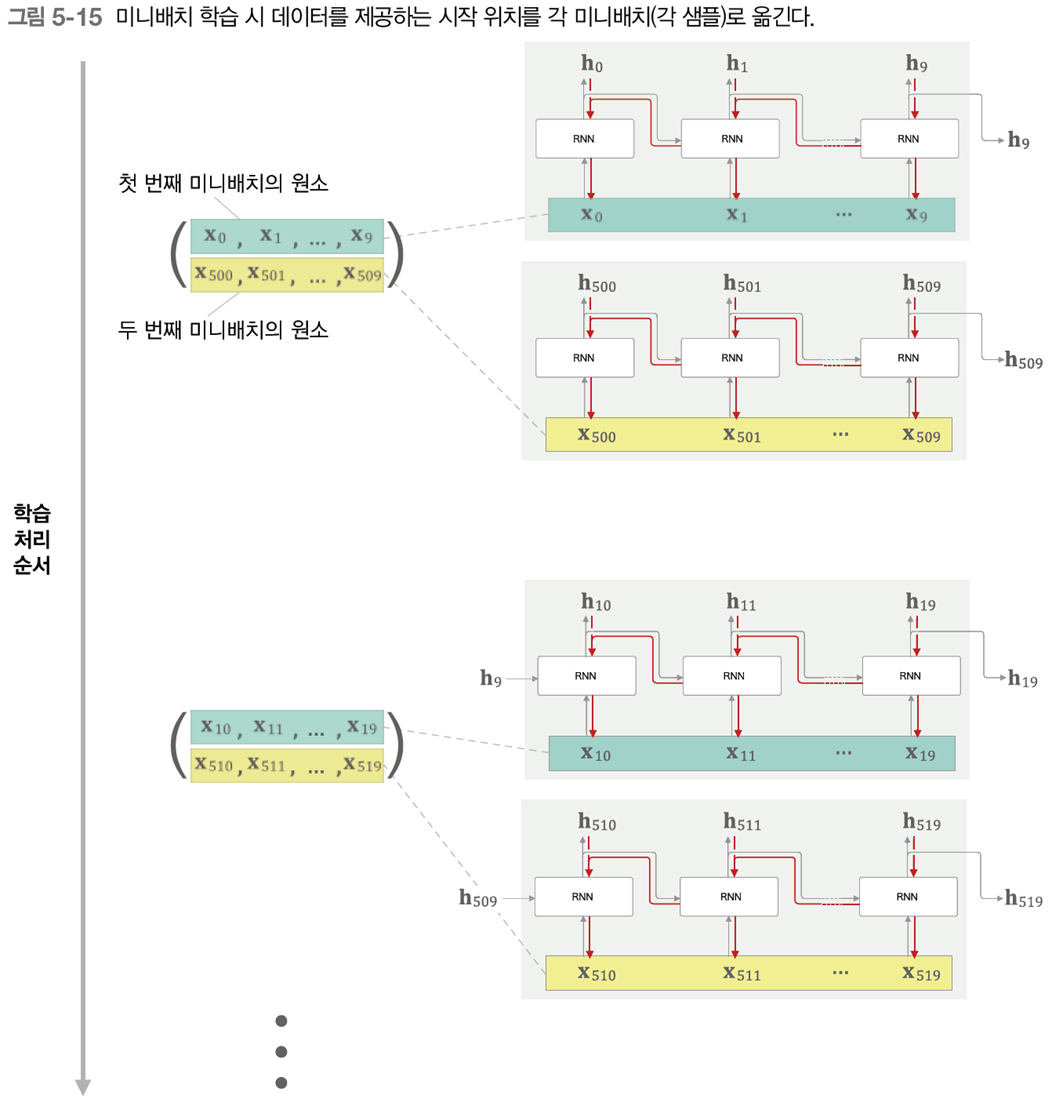

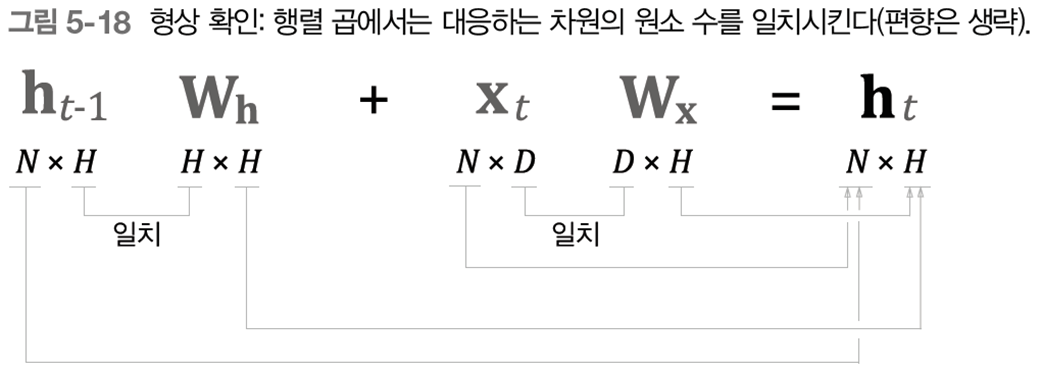 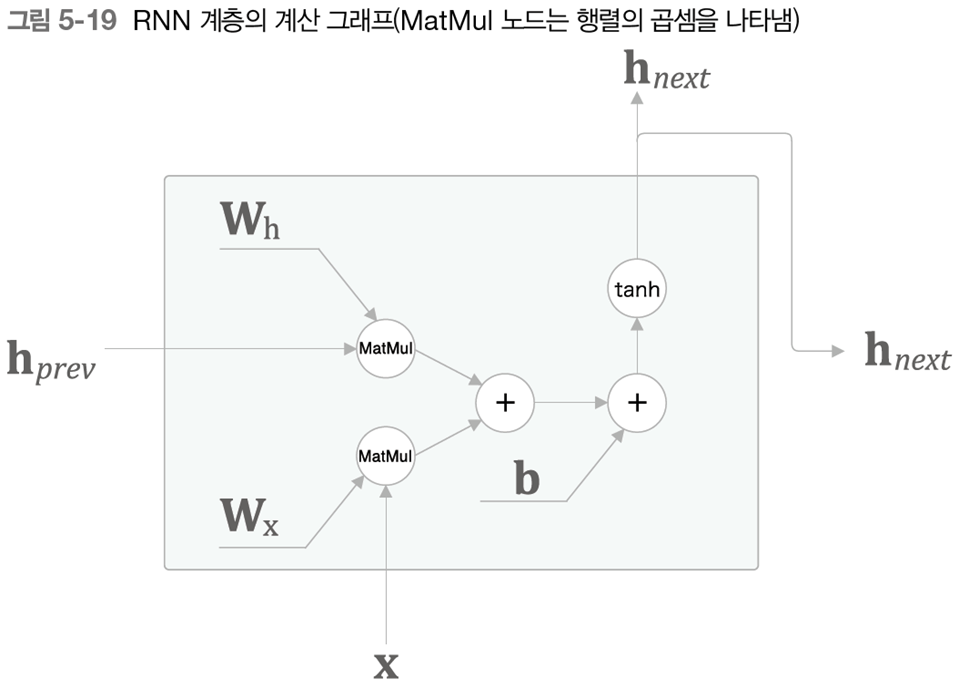

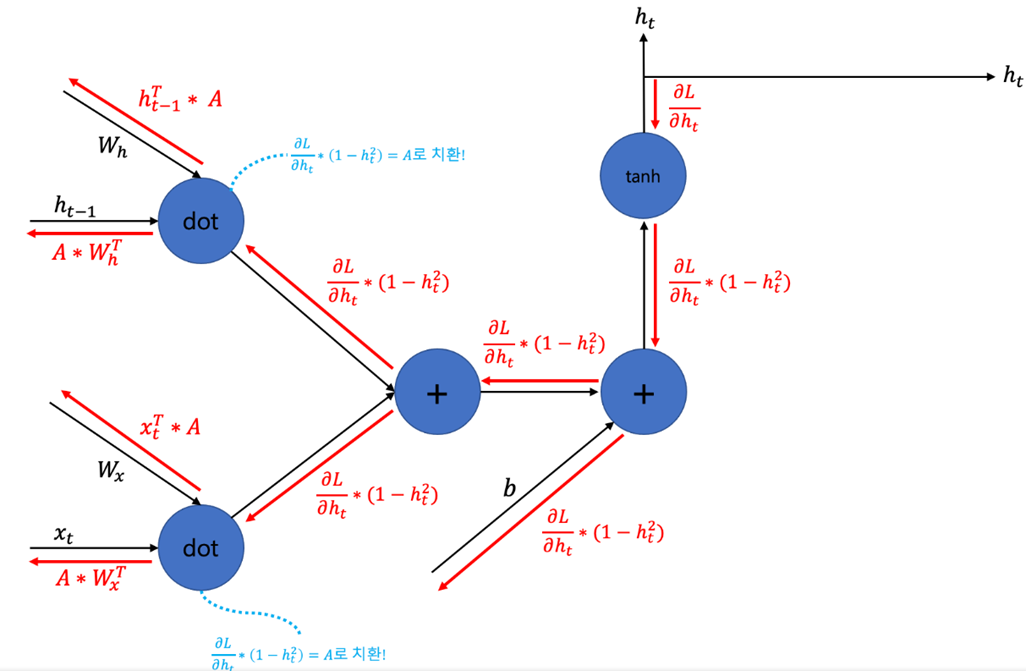

In [2]:
# tanh은 0~1인 sigmoid 확장판
# 미분 최대값은 1로 vanishing gradient를 막음
# sigmoid는 미분 최대 0.25라서 deep해질수록 vanishing
# relu는 rnn 반복 특성 때문에 y=x라 x가 1보다 큰 값 들어오면 반복하면서 발산할 수도 있다고함
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x , h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) # h_t
        h_next = np.tanh (t) # h_t
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1-h_next**2) # tanh
        db = np.sum(dt, axis=0) 
        # t = h_prev * Wh + x * Wx
        # dt >> + 는 그냥 흐른다
        # 1) h_prev * Wh
        dwh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        # 2) x * Wx
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        # 순서대로 grads 보관
        self.grads[0][...] = dWx
        self.grads[1][...] = dwh
        self.grads[2][...] = db

        return dx, dh_prev # dh_prev이 다음 역전파 때 쓰임
    

## time RNN (truncated BPTT)
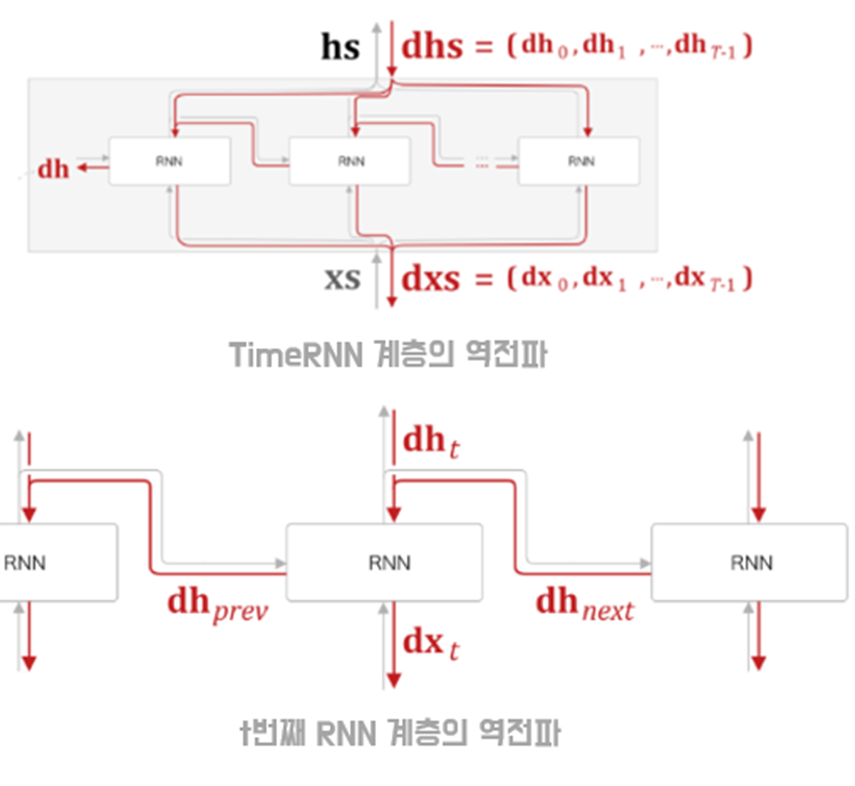

In [1]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False): # true일 때 h 통함, false면 0 행렬로 초기
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    # hidden state 넘겨주거나 다시 리셋하거나
    def set_state(self, h):
         self.h = h
    def reset_state(self):
        self.h = None

    def forward(self, xs): # T개 분량의 시계열 데이터 한 방에 모은거임
        Wx, Wh, b = self.params
        N, T, D = xs.shape # (batch, T개 시계열, 입력벡터차원)
        D, H = Wx.shape
        self.layers = []
        # 넘겨주는 hidden state
        hs = np.empty((N, T, H), dtype='f')  # 32bit
        
        if not self.stateful or self.h is None: # 가장 첫 h(h_prev)
            self.h = np.zeros((N, H), dype='f') # 어차피 time step 1개별로 연속적으로 쓸거라서 (,T,) 안들어가도 됨
                                                # 그리고 사실 다시 [:,t,:] shape의 hs에 할당해줄거라서 ㄱㅊ

        for t in range(T):
            layer = RNN(*self.params) # time 내에서 rnn 진행
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layer.append(layer) # time 별로 layer
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape # (input;x, hiidden)

        dxs = np.empty((N, T, D), dtype='f') # 얜 아예 "밑"으로 보낼거임
        dh = 0
        grads = [0, 0, 0] # Wx, Wh, b

        for t in reversed(range(T)):
            layer = self.layer[t] # RNN
            dx, dh = layer.backward(dhs[:, t,  :] + dh) # 전에 dh 더해줌
            dxs[:, t, :] = dx            
            # time 별로 gradient 따로 보관
            for i, grad in enumerate(layer.grads):
                grads[i] = grad
        # instance에 최종 grad 다 보관하기 (time 별로)
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs # [N. T, D]

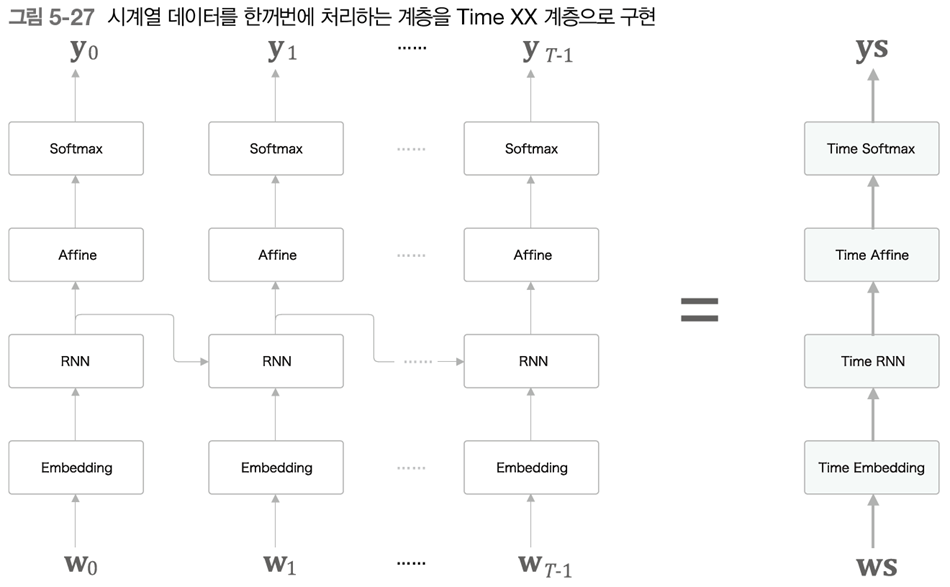 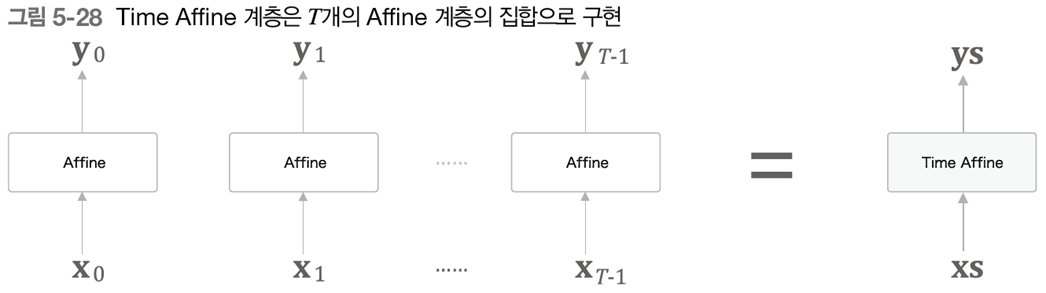

In [4]:
class TimeAffine: # T별로 한방에
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x): # rnn의 output은 hs다!!
        # T개의 Affine 계층 각각 계산 -> 행렬로 한번에!
        N, T, D = x.shape
        W, b = self.params # (H,T,V)
        # x = (N,T,H) -> (N*T,H) 2차원 dot위해
        rx = x.reshape(N*T, -1)
        # affine
        out = np.dot(rx, W) + b
        self.x = x # 역전파 때
        # (N,T,V)
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T) # (n*t, h), (d, h)
        dx = dx.reshape(*x.shape) 

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

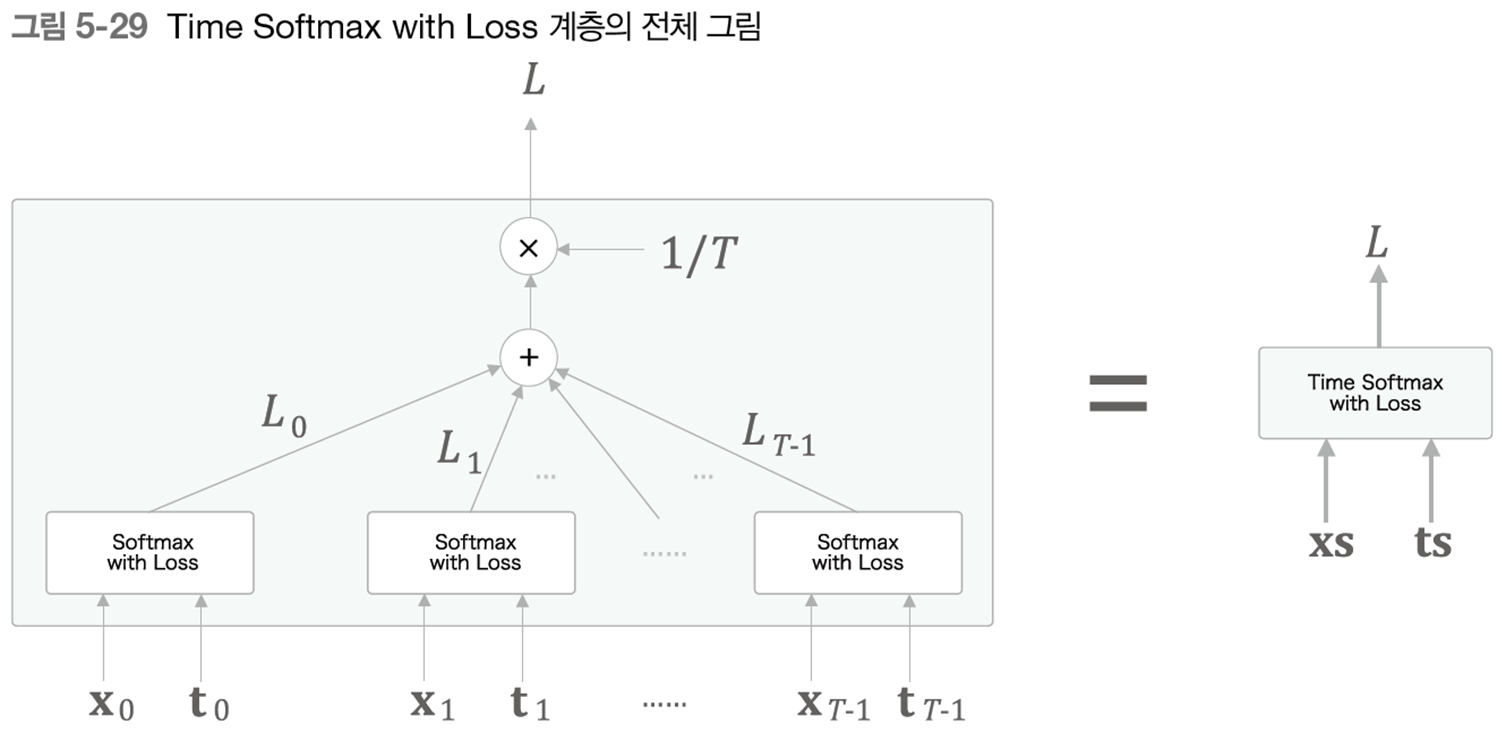

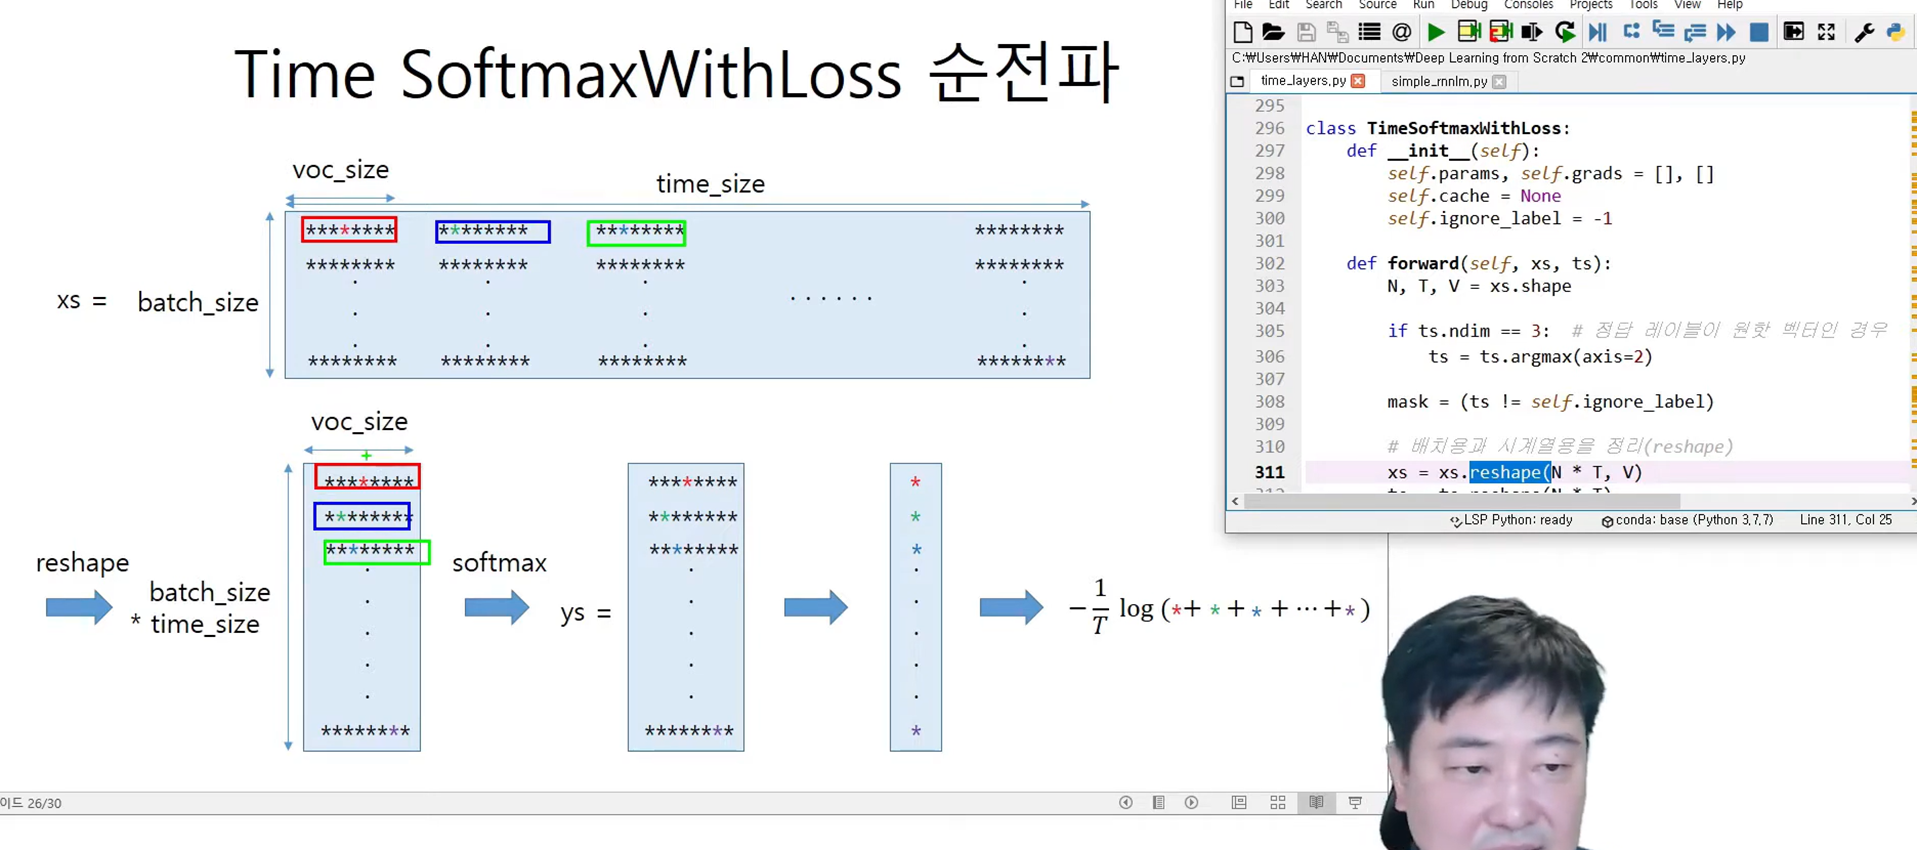
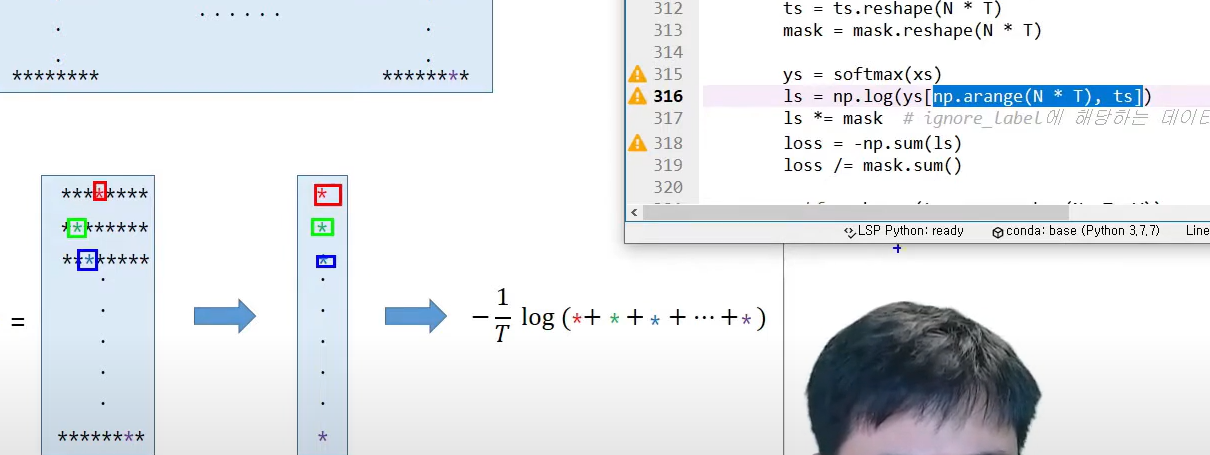

In [3]:
# x는 아랫층에서 전달 (N, T, H)
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1 # label은 원래 0이상이라 -1이면 아무것도 무시하지 않겠다는 뜻

    def forward(self, xs, ts): # logit, label
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우 (N,T,V)
            ts = ts.argmax(axis=2) # 정답 인덱스로 (N, T)

        mask = (ts != self.ignore_label) # ignore할 label은 False, 아니면 TRUE (N, T)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T) # flatten

        ys = softmax(xs)  # (N*T, V) 각 element가 확률 분포가 된다
        ls = np.log(ys[np.arange(N * T), ts]) # (N*T,V)의 ys에 대해, V에서 ts(정답레이블) 위치의 값만 뽑아냄 (위 캡쳐)
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum() # mask(=0) 뺴고 더하면 1x크기 만큼임 (배치 loss)

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1 # y - t (원래 미분이 error였잖아)
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정           
                                   # mask는 현재 (N*T)인 vector인데, np.newaxis하면 열벡터로(세로) 이해하겠다 (행렬계산위함)

        dx = dx.reshape((N, T, V)) # input shape 맞춰줌 (logit)

        return dx


In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 1. 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') # 0.01
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # He Normal Distribution (가중치제대로하면결과더좋으니까)
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 2. 계층 생성
        self.layers = [
            TimeEmbedding(embed_W), # T별 임베딩벡터 추출
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # h_prev*Wh + x_t*Wx + b
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1] # hidden_state reset 위해서

        # 3. 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.parmas
            self.grads += layer.grads
    
    def forward(self, xs, ts): # ts는 label 값
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss 
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state() # TimeRNN reset hidden(self.h)